# Project capstone Literify
Membuat model untuk mengklasifikasikan genre buku berdasarkan cover buku. Dataset yang akan dipakai adalah sebagai berikut :

## Import library yang akan digunakan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import re
import os
import string
from ast import literal_eval
import random
%matplotlib inline
import matplotlib.style as style
from urllib.request import urlopen
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.environ['TF_USE_LEGACY_KERAS'] = '1'

## Mengumpulkan data yang akan digunakan

In [ ]:
data_df = pd.read_csv('/content/books_data.csv')

## Menilai data yang sudah terkumpulkan

In [ ]:
data_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [ ]:
data_df.isna().sum()

,0
Title,1
description,68442
authors,31413
image,52075
previewLink,23836
publisher,75886
publishedDate,25305
infoLink,23836
categories,41199
ratingsCount,162652


In [ ]:
data_df.describe(include='all')

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
count,212403,143962,180991,160329,188568,136518,187099,188568,171205,49752.000000
unique,212403,133226,127278,149387,188099,16016,11582,184506,10883,NaN
top,Its Only Art If Its Well Hung!,Unlike some other reproductions of classic tex...,['Rose Arny'],http://books.google.com/books/content?id=7dMSA...,http://books.google.com/books?id=acwPAgAAQBAJ&...,Simon and Schuster,2000,https://play.google.com/store/books/details?id...,['Fiction'],NaN
freq,1,92,236,79,17,3454,4286,18,23419,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.252975
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.340431
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [ ]:
print(f"duplicate values:{data_df.duplicated().sum()}")

duplicate values:0


In [ ]:
data_df.dropna(inplace=True)
data_df.sample(20)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
10794,The Jazz Bass Book - Technique and Tradition B...,"Spilleteknisk, biografisk og historisk indføri...",['John Goldsby'],http://books.google.com/books/content?id=rKvAH...,http://books.google.nl/books?id=rKvAHdroxDQC&d...,Hal Leonard Corporation,2002,http://books.google.nl/books?id=rKvAHdroxDQC&d...,['Music'],1.0
9522,SAPscript,Designed as a comprehensive reference for prog...,"['Kogent Learning Solutions Inc.,']",http://books.google.com/books/content?id=fJ_4n...,http://books.google.nl/books?id=fJ_4n5lkHYYC&p...,Jones & Bartlett Learning,2009-10-15,http://books.google.nl/books?id=fJ_4n5lkHYYC&d...,['Computers'],2.0
195103,Zen Pivots: Lectures On Buddhism And Zen,"A companion to The Zen Eye, this volume contin...","['Sokei-an', 'Shigetsu Sasaki', 'Mary Farkas']",http://books.google.com/books/content?id=470KA...,http://books.google.com/books?id=470KAAAAYAAJ&...,"Weatherhill, Incorporated",1998,http://books.google.com/books?id=470KAAAAYAAJ&...,['Religion'],1.0
118944,Woe to Live on,Set in the border states of Kansas and Missour...,['Daniel Woodrell'],http://books.google.com/books/content?id=8bY5A...,http://books.google.nl/books?id=8bY5AQAAQBAJ&p...,Hachette UK,2012-06-19,https://play.google.com/store/books/details?id...,['Fiction'],5.0
85136,Globalization Of World Politics,This title provides an introduction to interna...,"['John Baylis', 'Steve Smith', 'Patricia Owens']",http://books.google.com/books/content?id=kH0oA...,http://books.google.com/books?id=kH0oAgAAQBAJ&...,Oxford University Press,2014,http://books.google.com/books?id=kH0oAgAAQBAJ&...,['Political Science'],1.0
92185,Night to Remember,"An absorbing, minute-by-minute account of the ...",['Walter Lord'],http://books.google.com/books/content?id=owCk6...,http://books.google.com/books?id=owCk6x5Z6gEC&...,Bantam,1997,http://books.google.com/books?id=owCk6x5Z6gEC&...,['History'],28.0
209813,Husband-Coached Childbirth : The Bradley Metho...,A revised and updated guide to the Bradley Met...,"['Robert A. Bradley, M.D.']",http://books.google.com/books/content?id=pQJgm...,http://books.google.com/books?id=pQJgmGikQH4C&...,Bantam,2008,http://books.google.com/books?id=pQJgmGikQH4C&...,['Health & Fitness'],4.0
45881,Sunlight on the Lawn,No more delightful garden-related books have e...,['Beverley Nichols'],http://books.google.com/books/content?id=KeRZ4...,http://books.google.com/books?id=KeRZ4ZLzxqwC&...,Timber Press (OR),1999-02,http://books.google.com/books?id=KeRZ4ZLzxqwC&...,['Biography & Autobiography'],2.0
177591,"The cost of discipleship,",Perhaps Dietrich Bonhoeffer’s most radical boo...,['Bonhoeffer Dietrich'],http://books.google.com/books/content?id=xGWmD...,http://books.google.com/books?id=xGWmDwAAQBAJ&...,SCM Press,2015-11-02,http://books.google.com/books?id=xGWmDwAAQBAJ&...,['Religion'],58.0
105161,Zondervan: Compact Bible Dictionary,This Bible dictionary is a readable fact and p...,['Al Bryant'],http://books.google.com/books/content?id=d0Ill...,http://books.google.com/books?id=d0IllwfUWuEC&...,Zondervan Publishing Company,1967,http://books.google.com/books?id=d0IllwfUWuEC&...,['Bible'],2.0


In [ ]:
data_df.shape

(40635, 10)

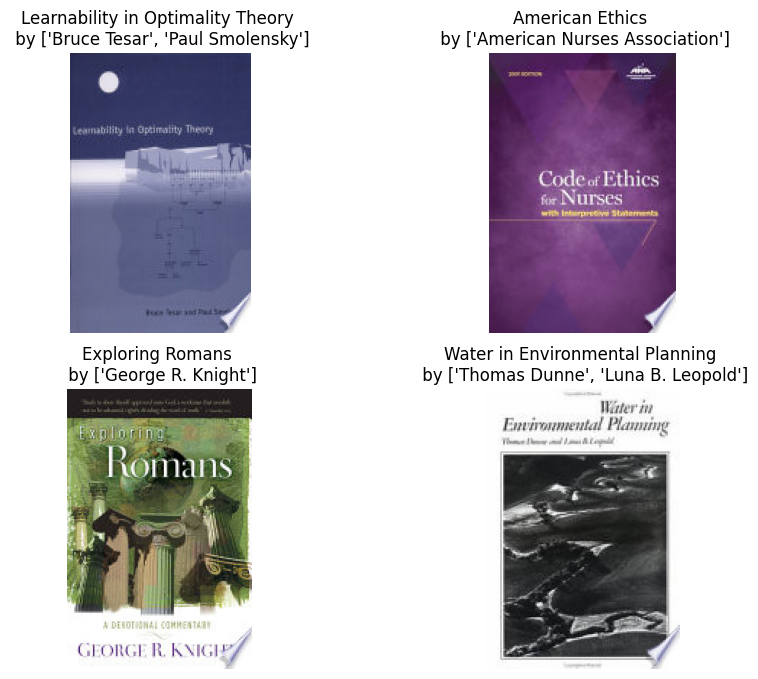

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
title_cover_df = data_df[["Title", 'image', 'authors']]
title_cover_df.dropna(inplace=True)
link = title_cover_df.image.values
title = title_cover_df.Title.values
authors = title_cover_df.authors.values

samples = random.sample(range(len(link)), 4)

for i, ax in enumerate(axes.flat):
    link_sample_image = link[samples[i]]
    image = urlopen(link_sample_image)
    image = np.array(Image.open(image))
    ax.set_title(f"{title[samples[i]]} \n by {authors[samples[i]]}")
    ax.imshow(image)
    ax.axis('off')

plt.show()

In [ ]:
data_df.drop(columns=["description", "previewLink", "publisher", "publishedDate", "infoLink", "ratingsCount"], inplace=True)
data_df

,Title,authors,image,categories
5,The Church of Christ: A Biblical Ecclesiology ...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,['Religion']
31,Voices from the Farm: Adventures in Community ...,['Rupert Fike'],http://books.google.com/books/content?id=IjTAB...,['Biography & Autobiography']
33,The Battleship Bismarck,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,['History']
42,Tess and the Highlander,['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,['Juvenile Fiction']
43,Beginner's Yoruba (Hippocrene Beginner's Series),['Kayode J. Fakinlede'],http://books.google.com/books/content?id=xLe4n...,['Foreign Language Study']
...,...,...,...,...
212374,Thin Within,"['Judy Halliday', 'Arthur Halliday']",http://books.google.com/books/content?id=L_YV_...,['Health & Fitness']
212392,The Awakening and Selected Stories (Modern Lib...,['Kate Chopin'],http://books.google.com/books/content?id=TDK4u...,['Adultery']
212394,Final things,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,['Fiction']
212399,The Orphan Of Ellis Island (Time Travel Advent...,['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,['Juvenile Fiction']


In [ ]:
data_df.shape

(40635, 4)

In [ ]:
def clean_category(sentences):
    text = sentences.lower()
    # Remove text in square brackets
    re.sub(r"\[.*?\]", "", text)
    # Removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Removing words containing digits
    text = re.sub('\w*\d\w*', '', text)

    return text

ex1 = r"'([\w+\s+|\w+\.\s+]*)'"
data_df["authors"] = data_df["authors"].apply(lambda x : ' '.join(re.findall(ex1, x)))
data_df['title_author'] = data_df[["Title", "authors"]].apply(lambda x:' '.join(x.tolist()).lower(), axis=1)

In [ ]:
data_df.sample(13)

,Title,authors,image,categories,title_author
98778,Reformation of the sixteenth century,Roland Bainton,http://books.google.com/books/content?id=u8v0E...,['Religion'],reformation of the sixteenth century roland ba...
134235,Take a Chance on Me (Silhouette Special Editio...,Karen Rose Smith,http://books.google.com/books/content?id=TgOOA...,['Fiction'],take a chance on me (silhouette special editio...
3144,Just Another Soldier: A Year on the Ground in ...,Jason Christopher Hartley,http://books.google.com/books/content?id=umUob...,['Political Science'],just another soldier: a year on the ground in ...
160824,Throwing the Elephant: Zen and the Art of Mana...,Stanley Bing,http://books.google.com/books/content?id=kPGaq...,['Business & Economics'],throwing the elephant: zen and the art of mana...
149423,Total War: Survivalist No. 1,Jerry Ahern,http://books.google.com/books/content?id=LB1zN...,['Fiction'],total war: survivalist no. 1 jerry ahern
139265,Immanuel Kant's Critique of Pure Reason,Immanuel Kant,http://books.google.com/books/content?id=atkvE...,['Philosophy'],immanuel kant's critique of pure reason immanu...
23851,LAST EXIT TO BROOKLYN,Hubert Selby,http://books.google.com/books/content?id=i4doA...,"['Brooklyn (New York, N.Y.)']",last exit to brooklyn hubert selby
119655,"Southeast Asia: Past And Present, Fifth Edition",David Ringrose,http://books.google.com/books/content?id=lg9dD...,['History'],"southeast asia: past and present, fifth editio..."
119711,Margaret Wise Brown's Pussy Willow (Little Gol...,Margaret Wise Brown,http://books.google.com/books/content?id=eoMz9...,['Juvenile Fiction'],margaret wise brown's pussy willow (little gol...
153777,The Throwback,Tom Sharpe,http://books.google.com/books/content?id=QtmeR...,['Fiction'],the throwback tom sharpe


In [ ]:
data_df.dropna(subset=['title_author'])
data_exploded = data_df.explode('categories')

top_categories = (
    data_exploded['categories']
    .value_counts()  # Count occurrences of each category
    .head(10)        # Get the top 10
    .index           # Extract category names
)

top_books = data_exploded[data_exploded['categories'].isin(top_categories)]

sorted_top_books = top_books.sort_values(by='categories')

In [ ]:
sorted_top_books.head()

,Title,authors,image,categories,title_author
26579,White dog,Romain Gary,http://books.google.com/books/content?id=1-qWL...,['Biography & Autobiography'],white dog romain gary
168602,T. E. Lawrence,John E. Mack,http://books.google.com/books/content?id=pnmSi...,['Biography & Autobiography'],t. e. lawrence john e. mack
168572,"Rolling stones,",Mick Jagger Keith Richards Charlie Watts Ron Wood,http://books.google.com/books/content?id=xP_S-...,['Biography & Autobiography'],"rolling stones, mick jagger keith richards cha..."
168464,Justice For All,Jim Newton,http://books.google.com/books/content?id=OkJRt...,['Biography & Autobiography'],justice for all jim newton
64677,Castles In The Air,Judy Corbett,http://books.google.com/books/content?id=d6LGD...,['Biography & Autobiography'],castles in the air judy corbett


In [ ]:
sorted_top_books["categories"] = sorted_top_books["categories"].apply(lambda x: literal_eval(x)[0])

In [ ]:
label_encoder = LabelEncoder()
sorted_top_books['genre_encoded'] = label_encoder.fit_transform(sorted_top_books['categories'])

In [ ]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
sorted_top_books

,Title,authors,image,categories,title_author,genre_encoded
26579,White dog,Romain Gary,http://books.google.com/books/content?id=1-qWL...,Biography & Autobiography,white dog romain gary,0
168602,T. E. Lawrence,John E. Mack,http://books.google.com/books/content?id=pnmSi...,Biography & Autobiography,t. e. lawrence john e. mack,0
168572,"Rolling stones,",Mick Jagger Keith Richards Charlie Watts Ron Wood,http://books.google.com/books/content?id=xP_S-...,Biography & Autobiography,"rolling stones, mick jagger keith richards cha...",0
168464,Justice For All,Jim Newton,http://books.google.com/books/content?id=OkJRt...,Biography & Autobiography,justice for all jim newton,0
64677,Castles In The Air,Judy Corbett,http://books.google.com/books/content?id=d6LGD...,Biography & Autobiography,castles in the air judy corbett,0
...,...,...,...,...,...,...
140348,World without women (Sharon),David F. Noble,http://books.google.com/books/content?id=kRHH6...,Social Science,world without women (sharon) david f. noble,9
190895,The Otoes and Missourias;: A study of Indian r...,,http://books.google.com/books/content?id=HKd6n...,Social Science,the otoes and missourias;: a study of indian r...,9
145647,Inside: Life Behind Bars in America,Michael Santos,http://books.google.com/books/content?id=xRebh...,Social Science,inside: life behind bars in america michael sa...,9
125088,Murder of Mercy,Anand Giridharadas,http://books.google.com/books/content?id=hiduA...,Social Science,murder of mercy anand giridharadas,9


In [ ]:
sorted_top_books['genre_encoded'].value_counts()

,count
genre_encoded,
3,11011
5,3326
7,2896
4,2448
0,2296
1,1057
6,1009
2,880
9,832


In [ ]:
vocab_text = set()
sorted_top_books["title_author"].str.lower().str.split().apply(vocab_text.update)
vocabulary_size = len(vocab_text)
print(vocabulary_size)

41508


In [ ]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 41509
MAX_LENGTH = 32
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    word_list = sentence.split()
    words = [w for w in word_list if w not in stopwords]
    sentence = " ".join(words)

    return sentence

In [ ]:
train_df, test_df = train_test_split(sorted_top_books[["title_author", "genre_encoded"]],test_size=0.2,random_state=42,stratify=sorted_top_books["genre_encoded"])

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print("Training set genre distribution:", train_df["genre_encoded"].value_counts(normalize=True))
print("Testing set genre distribution:", test_df["genre_encoded"].value_counts(normalize=True))
print("Validation set genre distribution:", val_df["genre_encoded"].value_counts(normalize=True))

Training set genre distribution: genre_encoded
3    0.416651
5    0.125875
7    0.109603
4    0.092621
0    0.086897
1    0.039972
6    0.038174
2    0.033302
9    0.031504
8    0.025402
Name: proportion, dtype: float64
Testing set genre distribution: genre_encoded
3    0.419977
5    0.124480
7    0.112751
4    0.090049
0    0.085509
1    0.043890
6    0.038593
2    0.032917
9    0.028377
8    0.023458
Name: proportion, dtype: float64
Validation set genre distribution: genre_encoded
3    0.413545
5    0.127128
7    0.106319
4    0.095346
0    0.088157
6    0.037836
1    0.036322
9    0.034431
2    0.033674
8    0.027242
Name: proportion, dtype: float64


In [ ]:
train_sentences = train_df['title_author'].apply(remove_stopwords).values
train_labels = train_df['genre_encoded'].values

test_sentences = test_df['title_author'].apply(remove_stopwords).values
test_labels = test_df['genre_encoded'].values

val_sentences = val_df['title_author'].apply(remove_stopwords).values
val_labels = val_df['genre_encoded'].values

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
vectorize_layer.adapt(train_sentences)

vocabulary = vectorize_layer.get_vocabulary()

with open('vectorizer_vocab.pkl', 'wb') as file:
    pickle.dump(vocabulary, file)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels))

In [ ]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  dataset_sequences = dataset.map(lambda text, label: (vectorize_layer(text), label))
  dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())
  sequences, labels = dataset_sequences.get_single_element()
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),maxlen=MAX_LENGTH,truncating=TRUNC_TYPE,padding=PADDING_TYPE)
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)
  return dataset_vectorized

In [ ]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)
validation_dataset_vectorized = validation_dataset.apply(preprocessing_fn)

In [ ]:
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   275,  6716,   926, 19654], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,  9275,  4258, 17269,   104,    11,     8,   191,
        3284,   934,  7366,  1308, 10365], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)



In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )
validation_dataset_final = (validation_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [ ]:
def make_model(vocab_size,embedding_dim):
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(10, activation="softmax")
  ])
  return model

In [ ]:
EMBEDDING_DIM = 100 # Increased embedding dimension further
EPOCHS = 300 # Increased epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True) # Increased patience further
model = make_model(VOCAB_SIZE, EMBEDDING_DIM)
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005), metrics=["accuracy"]) # Reduced learning rate

history = model.fit(train_dataset_final, validation_data=validation_dataset_final, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/300
661/661 [==============================] - 45s 36ms/step - loss: 1.6460 - accuracy: 0.4598 - val_loss: 1.5011 - val_accuracy: 0.4824
Epoch 2/300
661/661 [==============================] - 6s 10ms/step - loss: 1.2974 - accuracy: 0.5508 - val_loss: 1.4178 - val_accuracy: 0.5354
Epoch 3/300
661/661 [==============================] - 7s 10ms/step - loss: 0.9495 - accuracy: 0.6793 - val_loss: 1.3264 - val_accuracy: 0.5895
Epoch 4/300
661/661 [==============================] - 6s 10ms/step - loss: 0.6364 - accuracy: 0.7922 - val_loss: 1.3648 - val_accuracy: 0.6084
Epoch 5/300
661/661 [==============================] - 8s 12ms/step - loss: 0.4185 - accuracy: 0.8750 - val_loss: 1.4604 - val_accuracy: 0.6288
Epoch 6/300
661/661 [==============================] - 7s 11ms/step - loss: 0.2752 - accuracy: 0.9212 - val_loss: 1.5165 - val_accuracy: 0.6349
Epoch 7/300
661/661 [==============================] - 7s 11ms/step - loss: 0.1864 - accuracy: 0.9501 - val_loss: 1.5756 - val_accuracy

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

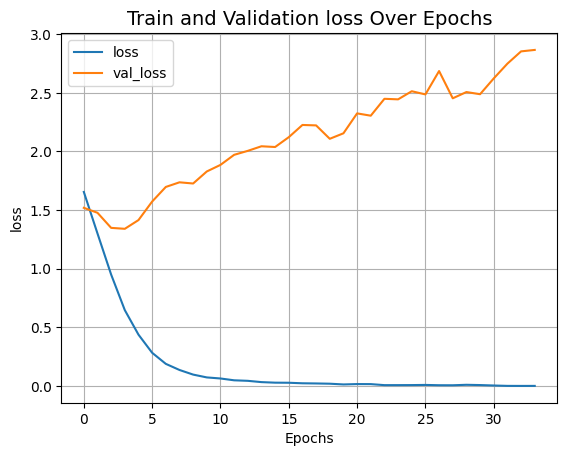

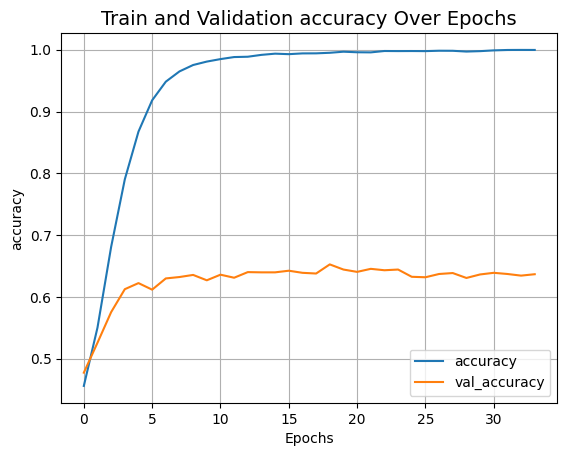

In [ ]:
plot_result("loss")
plot_result("accuracy")

In [ ]:
model.evaluate(test_dataset_final)

83/83 [==============================] - 1s 9ms/step - loss: 2.0641 - accuracy: 0.6565


[2.0640804767608643, 0.6564509868621826]

In [ ]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype=tf.string,trainable=False)

In [ ]:
train_sentences = train_df['title_author'].apply(remove_stopwords)
train_labels = train_df['genre_encoded']

test_sentences = test_df['title_author'].apply(remove_stopwords)
test_labels = test_df['genre_encoded']

val_sentences = val_df['title_author'].apply(remove_stopwords)
val_labels = val_df['genre_encoded']

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels))

def preprocessing_text(dataset):
  dataset = dataset.batch(BATCH_SIZE)
  dataset_sequences = dataset.map(lambda text, label: (sentence_encoder_layer(text), label))
  return dataset_sequences

In [ ]:
train_dataset = train_dataset.apply(preprocessing_text)
validation_dataset = validation_dataset.apply(preprocessing_text)
test_dataset = test_dataset.apply(preprocessing_text)

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset_final = (train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE))
test_dataset_final = (test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE))
validation_dataset_final = (validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE))

In [ ]:
for example in train_dataset_final.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32, 512), dtype=float32, numpy=
array([[ 2.3626820e-03, -6.0554653e-02,  1.8140329e-02, ...,
        -3.5095688e-02, -2.7925622e-02,  7.8673922e-03],
       [ 6.7921288e-02,  6.3970543e-02,  1.7098906e-05, ...,
         7.0973940e-02,  1.3842918e-02,  2.3978874e-02],
       [-2.9454041e-02, -2.8250640e-02, -2.2537239e-02, ...,
        -2.0126494e-02, -3.7962772e-02,  6.9834948e-02],
       ...,
       [-2.6051535e-03, -5.1964950e-02, -7.1749450e-03, ...,
        -1.0887189e-03, -1.4801017e-02,  5.2771393e-02],
       [ 4.2090748e-02,  2.5881426e-02,  4.2247836e-04, ...,
        -3.3624046e-02, -3.5740051e-02,  7.2429674e-03],
       [ 1.8323814e-02, -5.4206822e-02, -3.0204814e-02, ...,
        -1.4016335e-02,  1.2231388e-02,  5.8109630e-02]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([5, 4, 3, 4, 3, 3, 4, 3, 3, 2, 3, 3, 9, 4, 8, 1, 3, 3, 5, 5, 5, 4,
       3, 7, 3, 7, 9, 5, 3, 0, 5, 7])>)

(<tf.Tensor: shape=(32, 512), dtype=float32, numpy=

In [ ]:
def create_model():
  inputs = tf.keras.layers.Input(shape=[512,])
  x  = tf.keras.layers.Reshape((1,512))(inputs)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
  x = tf.keras.layers.Dense(64, activation="relu")(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
  model = tf.keras.Model(inputs, outputs)
  return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_w_universal_sentence_encoder = create_model()
model_w_universal_sentence_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
epochs = 200
history = model_w_universal_sentence_encoder.fit(train_dataset,validation_data=validation_dataset,epochs=epochs, callbacks=[early_stopping])

Epoch 1/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.4733 - loss: 1.6471 - val_accuracy: 0.6050 - val_loss: 1.1998
Epoch 2/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.5960 - loss: 1.2177 - val_accuracy: 0.6394 - val_loss: 1.1126
Epoch 3/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6188 - loss: 1.1433 - val_accuracy: 0.6428 - val_loss: 1.0887
Epoch 4/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6315 - loss: 1.1084 - val_accuracy: 0.6466 - val_loss: 1.0778
Epoch 5/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6395 - loss: 1.0820 - val_accuracy: 0.6515 - val_loss: 1.0698
Epoch 6/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.6511 - loss: 1.0571 - val_accuracy: 0.6527 - val_loss: 1.0633
Epoch 7/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6579 - loss: 1.0303 - val_accuracy: 0.6561 - val_loss: 1.0589
Epoch 8/200
661/661 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6680 - loss: 1

In [ ]:
model_w_universal_sentence_encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 1, 128)              │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,727,072 (6.59 MB)

 Trainable params: 575,690 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,151,382 (4.39 MB)

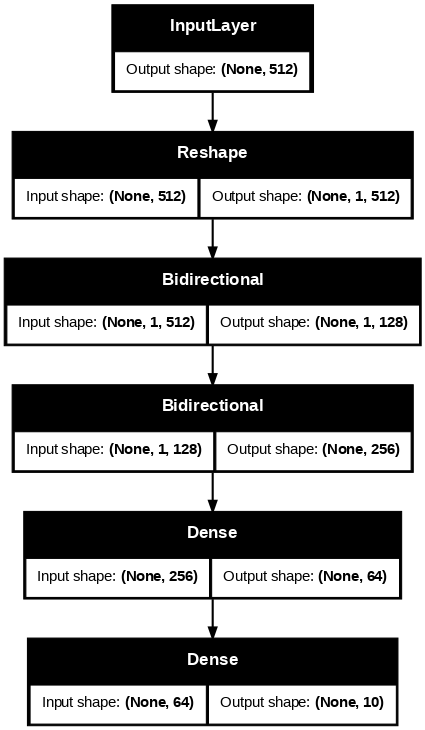

In [ ]:
tf.keras.utils.plot_model(model=model_w_universal_sentence_encoder,show_shapes=True,dpi=76)

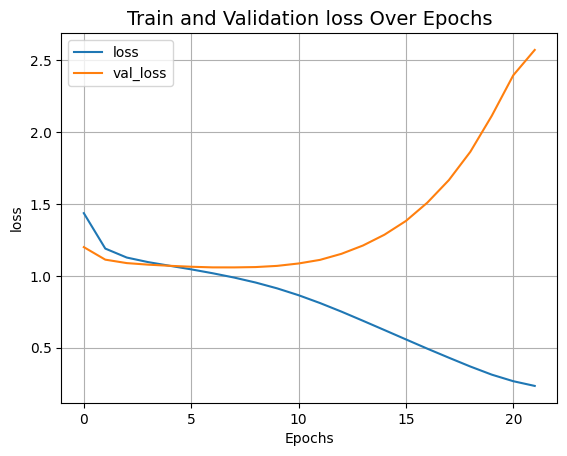

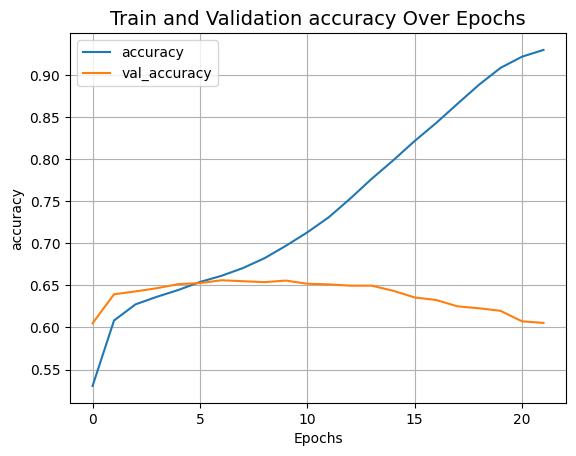

In [ ]:
plot_result("loss")
plot_result("accuracy")

In [ ]:
model_w_universal_sentence_encoder.evaluate(test_dataset_final)

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6155 - loss: 1.1603


[1.1458112001419067, 0.6280741691589355]